In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from utils import forecast_accuracy
from utils import test_stationary
from utils import read_oil_price
from utils import components_decomposition

from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [2]:
dataset = read_oil_price()
dataset.head()

,oil.price
Time,
1986-01-31,22.93
1986-02-28,15.45
1986-03-31,12.61
1986-04-30,12.84
1986-05-31,15.38


# Performing Grid Search HW's exponential smoothing

In [3]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from numpy import array

# one-step Holt Winter's Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    '''
    Takes in a list of contiguous prior observations and a list of config and train an HW's model
    
    trend (t): The type of trend component, as either “add” for additive or “mul” for multiplicative. Modeling the trend can be disabled by setting it to None.
    damped (d): Whether or not the trend component should be damped, either True or False.
    seasonal (s): The type of seasonal component, as either “add” for additive or “mul” for multiplicative. Modeling the seasonal component can be disabled by setting it to None.
    seasonal_periods (p): The number of time steps in a seasonal period, e.g. 12 for 12 months in a yearly seasonal structure.
    use_boxcox (b): Whether or not to perform a power transform of the series (True/False) or specify the lambda for the transform.
    remove_bias (r): Whether to remove bias when fitting
    
    '''
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error


# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)


# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores


# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

In [ ]:
cfg_list = exp_smoothing_configs(seasonal= [0,12])
scores = grid_search(list(dataset.values[:,0]), cfg_list, n_test = 12)

In [ ]:
print('Top 3')
for cfg, error in scores[:3]:
    print(cfg, error)

print('Bottom 3')
for cfg, error in scores[-3:]:
    print(cfg, error)
    

# Training and Testing up to Jan

In [4]:
train_til = datetime(year = 2005, month = 1, day= 1)
train = dataset[dataset.index < train_til]
test = dataset[dataset.index >= train_til]

In [5]:
t = 'add'
d = False
s = 'mul'
p = 12
b = False
r = False
model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p)
model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
pred = model.forecast(len(test))

/home/renjie/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/home/renjie/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [6]:
pred = pd.DataFrame(data = pred, index = test.index, columns = ['Predictions'])

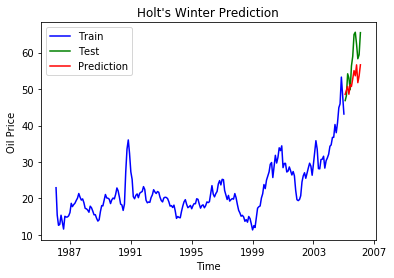

In [7]:
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.plot(train, c = 'b', label = 'Train')
plt.plot(test, c = 'g', label = 'Test')
plt.plot(pred, c = 'r', label = 'Prediction')
plt.title('Holt\'s Winter Prediction')
plt.legend(loc='best')
plt.show()

In [8]:
forecast_accuracy(pred['Predictions'], test['oil.price'])

/home/renjie/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'acf1': 0.4686643937730798,
 'corr': 0.8726697720453821,
 'mae': 5.606464402531071,
 'mape': 0.09353405650945758,
 'me': -4.907438441885863,
 'minmax': 0.09330957876118151,
 'mpe': -0.07901154732203744,
 'rmse': 6.4170765509115}

# Training and Testing up to Jul

In [9]:
train_til = datetime(year = 2005, month = 7, day= 1)
train = dataset[dataset.index < train_til]
test = dataset[dataset.index >= train_til]

In [10]:
t = 'add'
d = False
s = 'mul'
p = 12
b = False
r = False
model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p)
model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
pred = model.forecast(len(test))

/home/renjie/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/home/renjie/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [11]:
pred = pd.DataFrame(data = pred, index = test.index, columns = ['Predictions'])

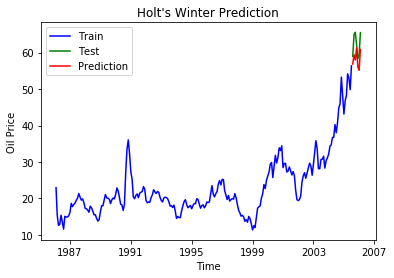

In [12]:
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.plot(train, c = 'b', label = 'Train')
plt.plot(test, c = 'g', label = 'Test')
plt.plot(pred, c = 'r', label = 'Prediction')
plt.title('Holt\'s Winter Prediction')
plt.legend(loc='best')
plt.show()

In [13]:
forecast_accuracy(pred['Predictions'], test['oil.price'])

/home/renjie/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'acf1': -0.09652160172365341,
 'corr': 0.7017193519727949,
 'mae': 3.908412024803922,
 'mape': 0.061916278735913356,
 'me': -3.908412024803922,
 'minmax': 0.06191627873591343,
 'mpe': -0.061916278735913356,
 'rmse': 4.456552328151666}